# 0: Imports

In [1]:
import dsdtools
import pandas as pd
import os
import librosa
import numpy as np
import math
import seaborn as sns
import json
from matplotlib import pyplot as plt

# 1: Exploratory Data Analysis

## 1.1: About DSD100

>The dsd100 is a dataset of 100 full lengths music tracks of different styles along with their isolated drums, bass, vocals and others stems.
> dsd100 contains two folders, a folder with a training set: "train", composed of 50 songs, and a folder with a test set: "test", composed of 50 songs. Supervised approaches should be trained on the training set and tested on both sets.
>For each file, the mixture correspond to the sum of all the signals. All signals are stereophonic and encoded at 44.1kHz.
>> [Source](https://sigsep.github.io/datasets/dsd100.html)

In [2]:
# Get path of folder for dsdtools and excel sheet inside folder for preliminary EDA
path = os.path.abspath('DSD100')
excel_sheet = os.path.abspath('DSD100/dsd100.xlsx')

In [3]:
excel = pd.read_excel(excel_sheet)
excel.head()

,Name,Style,Duration
0,Actions - Devil's Words,Power Pop,3'17''
1,Actions - One Minute Smile,Power Pop,2'44''
2,Actions - South Of The Water,Power Pop,3'11''
3,Al James - Schoolboy Facination,Bubblegum Pop,3'21''
4,AM Contra - Heart Peripheral,Electronic Dance Pop,3'30''


## 1.2 Duration Exploration

Generally, the type of style (or genre) may affect separation due to various instruments being used. However, because of how the dataset was prepared, the targets to separate are drums, bass, vocals and others. Because of this, style is simply a descriptive attribute that will not affect separation.

Instead, we will view the distribution of the length of songs in minutes to get a reasonable assesment of what to expect from the songs. The longer the song, the more data there is. This should intuitively make sense.

/home/asabra/anaconda3/envs/thesis/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


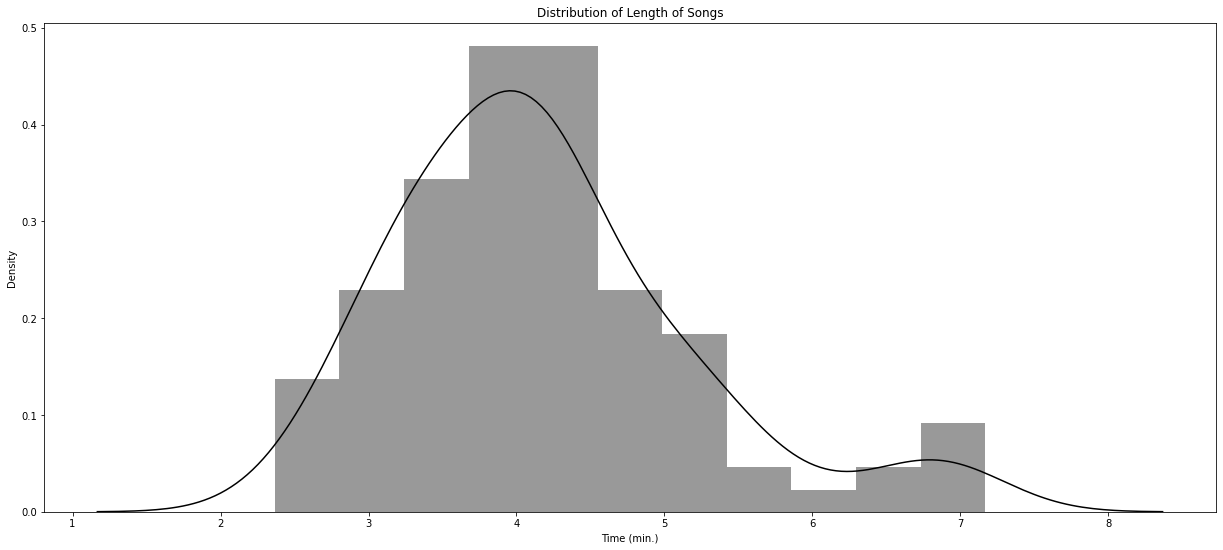

In [4]:
length = []
# Length is in a string format. 
# The minutes and seconds are parsed and converted into float
for time in excel.Duration:
  min = int(time[0])
  seconds = round(float(int(time[2:4]) / 60), 3) # Rounded to 3 decimal places
  length.append(min + seconds)

fig, ax = plt.subplots(1,1, figsize = (21,9))
plt.title('Distribution of Length of Songs')
sns.distplot(length, color='black', axlabel='Time (min.)')
plt.show()

## 1.3: Visualization of the Time Domain

In this section, we'll play around with visualisations. I will be using one track for simplicity's sake.

In [5]:
dsd = dsdtools.DB(path)
tracks = dsd.load_dsd_tracks('Dev') # Test set
audio = tracks[0].audio
sr = tracks[0].rate
vocals = tracks[0].targets['vocals'].audio
time = np.linspace(0, len(audio)/sr , num=len(audio))

/home/asabra/anaconda3/envs/thesis/lib/python3.8/site-packages/dsdtools/__init__.py:100: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.setup = yaml.load(f)


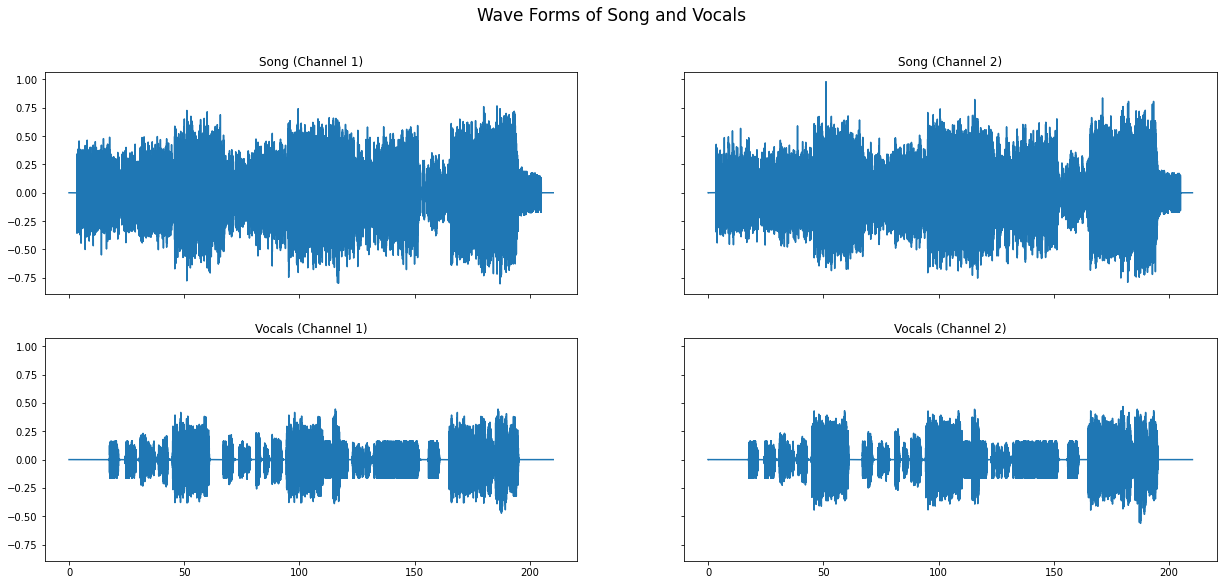

In [6]:
fig, ax = plt.subplots(2,2, figsize = (21,9), sharex=True, sharey=True)
fig.suptitle('Wave Forms of Song and Vocals', fontsize = 17)
ax[0,0].set_title('Song (Channel 1)')
ax[0,0].plot(time, audio[:, 0])
ax[0,1].set_title('Song (Channel 2)')
ax[0,1].plot(time, audio[:, 1])
ax[1,0].set_title('Vocals (Channel 1)')
ax[1,0].plot(time, vocals[:, 0])
ax[1,1].set_title('Vocals (Channel 2)')
ax[1,1].plot(time, vocals[:, 1])

Note that the songs and stems contain 2 channels - or is stereophonic. This does not make working with audio any more/less difficult to process and will actually allow us to utilize more information than a monophonic song - or 1 channel.

Think of a grayscale picture (1 layer) versus a colored picture with RGB (3 layers.)

## 1.4: Visualisation of the Frequency Domain

Now the fun stuff - audio transformations. We transform audio to view the properties of the signals in each song. Signal Processing techniques also help us visualise/paramaterize the signals at each moment in time.

For these visualizations we will be looking at the first channel of the song and vocals. However, when the model undergoes preprocessing, it will use both channels.

### 1.4.1: Short Time Fourier Transformation

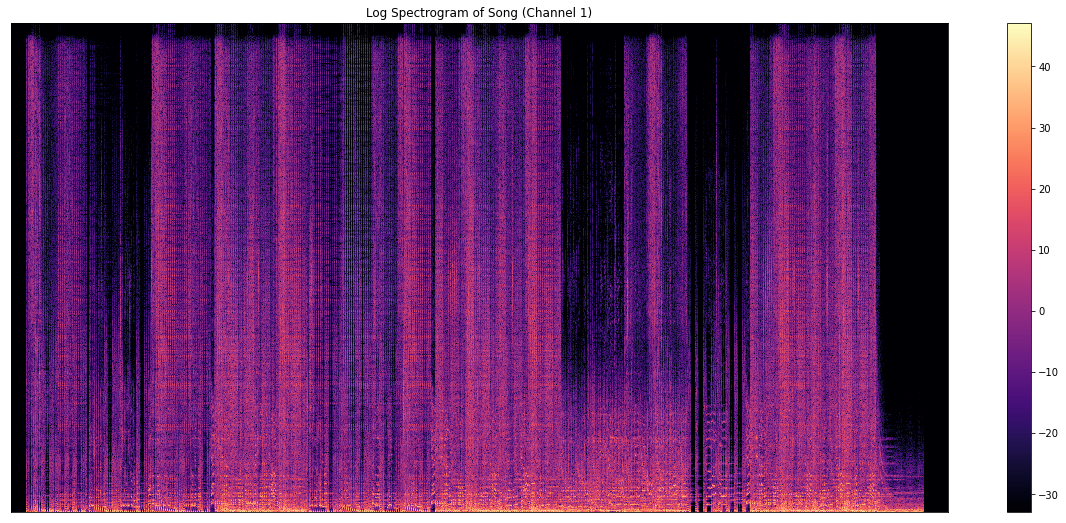

In [7]:
import librosa.display as ld
hop_length = 512
n_fft = 2048

spec_song = np.abs(librosa.core.stft(audio[:, 0], n_fft = n_fft,
                                     hop_length=hop_length))
log_spec_song = librosa.amplitude_to_db(spec_song)
fig, ax = plt.subplots(figsize = (21,9))
ax.set_title('Log Spectrogram of Song (Channel 1)')
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ld.specshow(log_spec_song, sr = sr, hop_length=hop_length, 
            cmap = 'magma')
plt.colorbar()
plt.show()

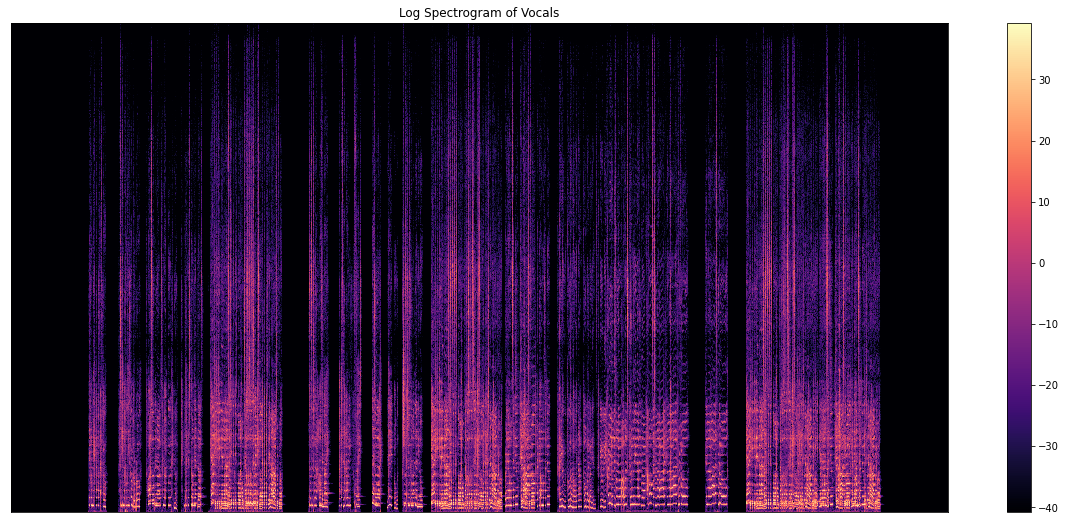

In [8]:
spec_vocals = np.abs(librosa.core.stft(vocals[:, 0], hop_length = hop_length,
                                       n_fft = n_fft))
log_spec_vocals = librosa.amplitude_to_db(spec_vocals)
fig, ax = plt.subplots(figsize = (21,9))
ax.set_title('Log Spectrogram of Vocals')
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ld.specshow(log_spec_vocals, sr = sr, hop_length=hop_length, 
            cmap = 'magma')
plt.colorbar()
plt.show()

### 1.4.2: MFCCs

In [9]:
MFCC_audio = librosa.feature.mfcc(audio[:, 0], n_fft=n_fft, 
                                   hop_length=hop_length, sr=sr, 
                                   n_mfcc = 13)

MFCC_vocals = librosa.feature.mfcc(vocals[:, 0], n_fft=n_fft, 
                                   hop_length=hop_length, sr=sr, 
                                   n_mfcc = 13)

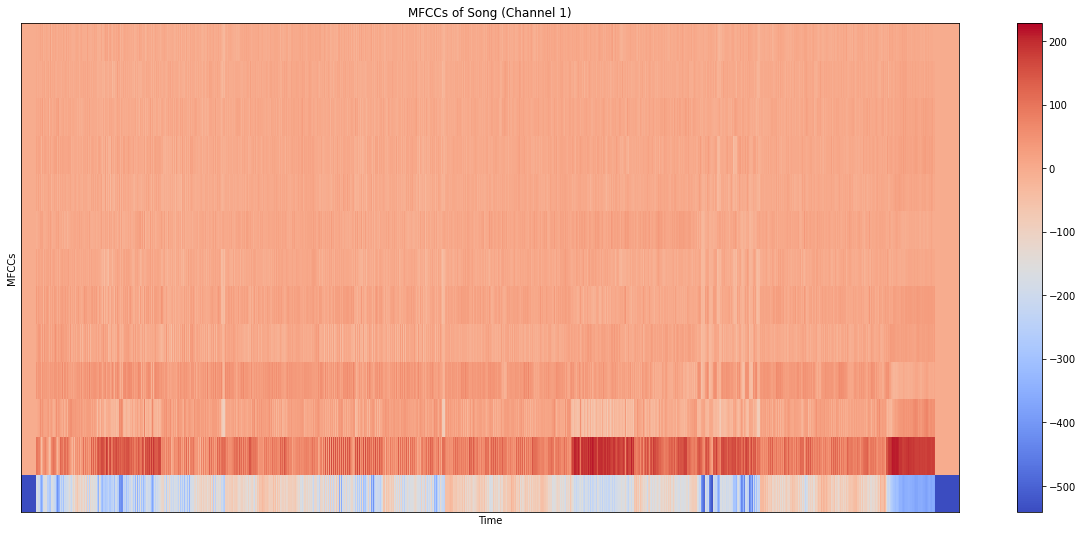

In [10]:
fig, ax = plt.subplots(figsize = (21,9))
ax.set_title('MFCCs of Song (Channel 1)')
ld.specshow(MFCC_audio, sr = sr, hop_length=hop_length)
ax.set_xlabel('Time')
ax.set_ylabel('MFCCs')
plt.colorbar()
plt.show()

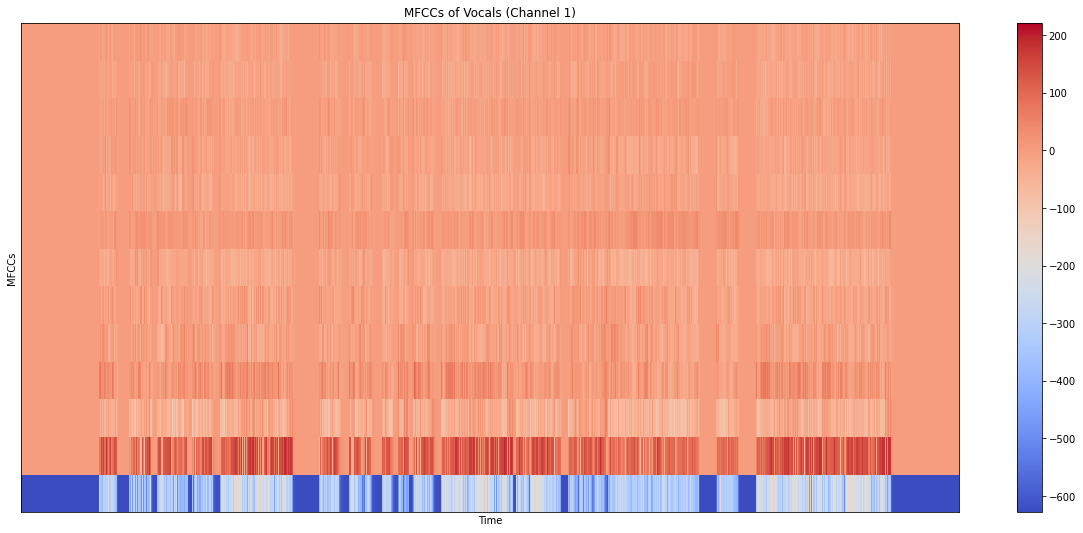

In [11]:
fig, ax = plt.subplots(figsize = (21,9))
ax.set_title('MFCCs of Vocals (Channel 1)')
ld.specshow(MFCC_vocals, sr = sr, hop_length=hop_length)
ax.set_xlabel('Time')
ax.set_ylabel('MFCCs')
plt.colorbar()
plt.show()